In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rawpy
import cv2
from scipy.signal import convolve2d
from tqdm import tqdm

In [2]:
x = np.load('IMG_9939.npy')
print('Loaded array of size', x.shape)
print('The pens, from top to bottom, are red, green and blue')

Loaded array of size (4014, 6020)
The pens, from top to bottom, are red, green and blue


In [3]:
def identify_bayer_pattern_from_data(x):
    patterns = {
        "C1": "RGGB",
        "C2": "GRBG",
        "C3": "GBRG",
        "C4": "BGGR"
    }

    # Assuming data is a 2D array representing image sensor data
    height, width = len(x), len(x[0])

    # Initialize counters for each pattern
    count_c1, count_c2, count_c3, count_c4 = 0, 0, 0, 0

    # Sample a smaller region (2x2) and create a flattened numpy array
    sample = np.array([x[i][:2] for i in range(2)]).flatten()
    #for i in tqdm(range(0, height, 2)):
        #for j in range(0, width, 2):
            #sample = np.array(x[i:i+1,j:j+1]).flatten()
            # print(sample.shape)
            # print(sample)

            # Count occurrences of red, blue, and green pixels
    red_count = np.sum(sample[::2])
    blue_count = np.sum(sample[1::2])
    green_count = np.sum(sample[1:-1:2])

    # Based on the color distribution, update the counters
    if red_count > blue_count and red_count > green_count:
        count_c1 += 1
    elif blue_count > red_count and blue_count > green_count:
        count_c4 += 1
    elif green_count > red_count and green_count > blue_count:
        count_c2 += 1
    else:
        count_c3 += 1

    # Determine the overall Bayer pattern based on the highest count
    max_count = max(count_c1, count_c2, count_c3, count_c4)
    if max_count == count_c1:
        return patterns["C1"]
    elif max_count == count_c2:
        return patterns["C2"]
    elif max_count == count_c3:
        return patterns["C3"]
    else:
        return patterns["C4"]
            # Based on the color distribution, make an educated guess
            # if red_count > blue_count and red_count > green_count:
            #     return patterns["C1"]
            # elif blue_count > red_count and blue_count > green_count:
            #     return patterns["C4"]
            # elif green_count > red_count and green_count > blue_count:
            #     return patterns["C2"]
            # else:
            #     return patterns["C3"]


# Assuming 'image_data' is your raw image data
identified_pattern = identify_bayer_pattern_from_data(x)
print(f"The identified Bayer pattern is: {identified_pattern}")

The identified Bayer pattern is: RGGB


In [4]:
# Load the CR3 image #/Users/pankajrathi/Projcv/exercise_2_data/06/00.CR3## #03/IMG_4782.CR3   /Users/pankajrathi/Projcv/exercise_2_data/02/IMG_3044.CR3
raw_data = rawpy.imread('/Users/pankajrathi/Projcv/exercise_2_data/03/IMG_4782.CR3')
image_data = raw_data.raw_image_visible  # Assuming 14-bit data

# Identify the Bayer pattern
identified_pattern = identify_bayer_pattern_from_data(image_data)

print(f"The identified Bayer pattern is: {identified_pattern}")

The identified Bayer pattern is: RGGB


In [82]:
def encode_14bit_to_8bit(data_14bit):
    # Assuming data_14bit is a NumPy array or a list containing 14-bit data
    max_14bit_value = 2**14 - 1  # Maximum value for 14-bit data
    scale_factor = 255 / max_14bit_value

    # Linear scaling to the range [0, 255]
    encoded_data_8bit = (data_14bit * scale_factor).astype(int)

    return encoded_data_8bit

In [83]:
image_data_14bit = encode_14bit_to_8bit(image_data)

In [84]:
# Identify the Bayer pattern
identified_pattern = identify_bayer_pattern_from_data(image_data_14bit)

print(f"The identified Bayer pattern is: {identified_pattern}")

The identified Bayer pattern is: RGGB


In [85]:
def bayer(im):
    r = np.zeros(im.shape[:2])
    g = np.zeros(im.shape[:2])
    b = np.zeros(im.shape[:2])
    r[0::2, 0::2] += im[0::2, 0::2]
    g[0::2, 1::2] += im[0::2, 1::2]
    g[1::2, 0::2] += im[1::2, 0::2]
    b[1::2, 1::2] += im[1::2, 1::2]
    return r, g, b

In [ ]:
# def bilinear(im):
#     r, g, b = bayer(im)
#
#     # green interpolation
#     k_g = 1/4 * np.array([[0,1,0],[1,0,1],[0,1,0]])
#     convg =convolve2d(g, k_g, 'same')
#     g = g + convg
#     print(g.shape)
#
#     # red interpolation
#     k_r_1 = 1/4 * np.array([[1,0,1],[0,0,0],[1,0,1]])
#     convr1 =convolve2d(r, k_r_1, 'same')
#     convr2 =convolve2d(r+convr1, k_g, 'same')
#     r = r + convr1 + convr2
#     print(r.shape)
#
#     # blue interpolation
#     k_b_1 = 1/4 * np.array([[1,0,1],[0,0,0],[1,0,1]])
#     convb1 =convolve2d(b, k_b_1, 'same')
#     convb2 =convolve2d(b+convb1, k_g, 'same')
#     b = b + convb1 + convb2
#     print(b.shape)
#
#     return r, g, b

In [86]:
def bilinear(im):
    r, g, b = bayer(im)

    # Define kernels
    k_g = 1/4 * np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    k_r = 1/4 * np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
    k_b = 1/4 * np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])

    # Compute color channel C using the formula C = ((Mc×X)⊗K) / (Mc⊗K)

    g = g + convolve2d(g, k_g, 'same') / convolve2d(np.ones_like(g), k_g, 'same')
    r = r + (convolve2d(r, k_r, 'same') + convolve2d(r + convolve2d(r, k_r, 'same'), k_g, 'same')) / (convolve2d(np.ones_like(r), k_r, 'same') + convolve2d(np.ones_like(r), k_g, 'same'))
    b = b + (convolve2d(b, k_b, 'same') + convolve2d(b + convolve2d(b, k_b, 'same'), k_g, 'same')) / (convolve2d(np.ones_like(b), k_b, 'same') + convolve2d(np.ones_like(b), k_g, 'same'))

    return r, g, b

In [ ]:
# def bayer_to_yuv(im):
#     r, g, b  = bayer(im)
#     # Convert the RGB channels to the YUV color space
#     conversion_matrix = np.array([[0.299, 0.587, 0.114],
#                                   [-0.168736, -0.331264, 0.5],
#                                   [0.5, -0.418688, -0.081312]])
#
#     yuv_image = (
#         r * conversion_matrix[0, 0] +
#         g * conversion_matrix[0, 1] +
#         b * conversion_matrix[0, 2]
#     )
#
#     return yuv_image
# def yuv_to_rgb(yuv_image):
#     conversion_matrix = np.array([[1, 0, 1.13983],
#                                   [1, -0.39465, -0.58060],
#                                   [1, 2.03211, 0]])
#
#     rgb_image = (
#         yuv_image * conversion_matrix[0, 0] +
#         yuv_image * conversion_matrix[0, 1] +
#         yuv_image * conversion_matrix[0, 2]
#     )
#
#     return rgb_image
# def bayer_to_rgb(im):
#     yuv_image = bayer_to_yuv(im)
#     rgb_image = yuv_to_rgb(yuv_image)
#     return rgb_image

In [87]:
bayer_r, bayer_g, bayer_b = bayer(image_data_14bit)
result_image_bayer = np.dstack([bayer_r, bayer_g, bayer_b])
result_image_bayer.shape

(4660, 6984, 3)

In [88]:
r, g, b = bilinear(image_data_14bit)

In [89]:
result_image = np.dstack([r, g, b])
result_image.shape

(4660, 6984, 3)

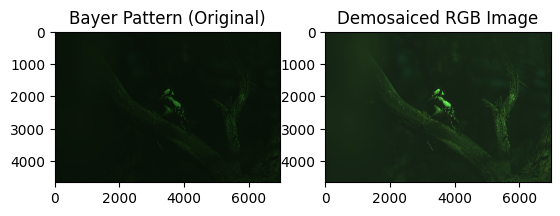

In [90]:
# Plot the original Bayer pattern image
plt.subplot(1, 2, 1)
plt.imshow(result_image_bayer.astype(np.uint8))
plt.title('Bayer Pattern (Original)')

# Plot the demosaiced RGB image
plt.subplot(1, 2, 2)
plt.imshow(result_image.astype(np.uint8))
plt.title('Demosaiced RGB Image')

plt.show()

In [91]:
gamma_value = 0.3
def percentile_normalize(image_data):
    a = np.percentile(image_data, 0.01)
    b = np.percentile(image_data, 99.99)

    # Normalize to the range [0, 1] using min and max values
    normalized_data = (image_data - a)/(b-a)

    #range [0,1]
    normalized_data[normalized_data<0] = 0
    normalized_data[normalized_data>1] = 1

    # Apply gamma correction
    img_corrected = np.power(normalized_data , gamma_value)

    # Invert the transform to get back to the previous range of values
    img_corrected = (img_corrected * (b - a)) + a
    return img_corrected

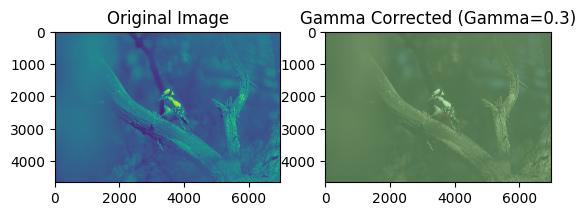

In [92]:
# Apply gamma correction
corrected_image = percentile_normalize(result_image)
#original image
normalized_image =percentile_normalize(image_data_14bit)

# Display the original and corrected images
plt.subplot(1, 2, 1)
plt.imshow(normalized_image.astype(np.uint8))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(corrected_image.astype(np.uint8))
plt.title(f'Gamma Corrected (Gamma={gamma_value})')

plt.show()

In [93]:
# White balancing
def whitebalance(image_data):
    mean_image = np.mean(image_data)
    mean_red = np.mean(image_data[:, :, 0])
    mean_green = np.mean(image_data[:, :, 1])
    mean_blue = np.mean(image_data[:, :, 2])

    image_data[:, :, 0] = image_data[:, :, 0] * mean_image // mean_red
    image_data[:, :, 1] = image_data[:, :, 1] * mean_image // mean_green
    image_data[:, :, 2] = image_data[:, :, 2] * mean_image // mean_blue

    clipped_array = np.clip(image_data, 0, 255)
    return clipped_array

In [94]:
whitebalance_image = whitebalance(corrected_image)

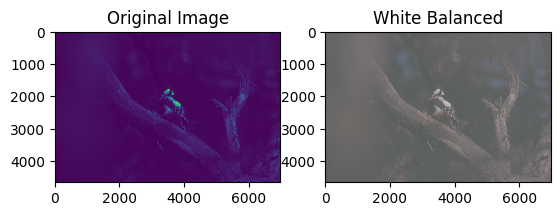

In [95]:
# Display the original and corrected images
plt.subplot(1, 2, 1)
plt.imshow(image_data_14bit.astype(np.uint8))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(whitebalance_image.astype(np.uint8))
plt.title('White Balanced')

plt.show()